In [28]:
import os
# from google.colab import drive
# drive.mount('/content/drive')

# !cp -r "/content/drive/MyDrive/Mushrooms" ./Mushrooms

# os.getcwd()

In [29]:
import random
import numpy as np
from collections import Counter
import seaborn as sns
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split, Subset, WeightedRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import os
import time
import copy
from PIL import ImageFile, Image
import warnings
warnings.filterwarnings('ignore')

ImageFile.LOAD_TRUNCATED_IMAGES = True

randomSeed = 42
random.seed(randomSeed)
np.random.seed(randomSeed)
torch.manual_seed(randomSeed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


### Трансформации для изображений


In [30]:
trainTransform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
testTransform = transforms.Compose([
    transforms.Resize(int(224*1.14)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

### Загрузка датасета

Размер полного датасета: 6714
Классы: ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']


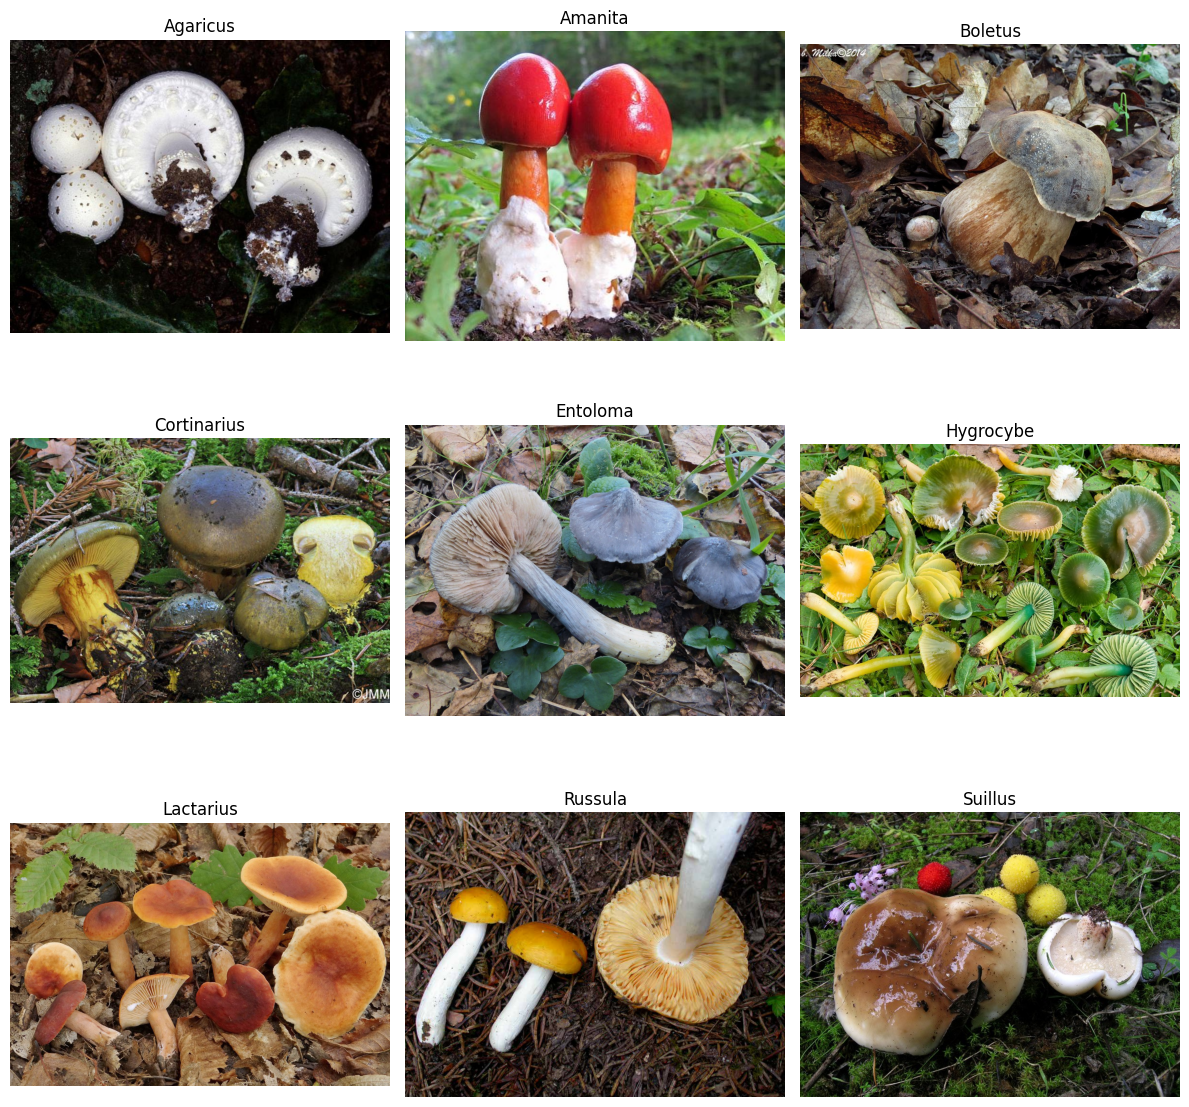

In [31]:
dataDir = './Mushrooms'

fullDataset = datasets.ImageFolder(dataDir, transform=trainTransform)
numClasses = len(fullDataset.classes)

imagesPerClass = {}
for path, label in fullDataset.samples:
    if label not in imagesPerClass:
        imagesPerClass[label] = path
    if len(imagesPerClass) == numClasses:
        break

print("Размер полного датасета:", len(fullDataset))
print("Классы:", fullDataset.classes)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.ravel()

for idx, (label, imgPath) in enumerate(imagesPerClass.items()):
    imgObject = Image.open(imgPath)
    axes[idx].imshow(imgObject)
    axes[idx].set_title(fullDataset.classes[label], fontsize=12)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### Дисбаланс классов

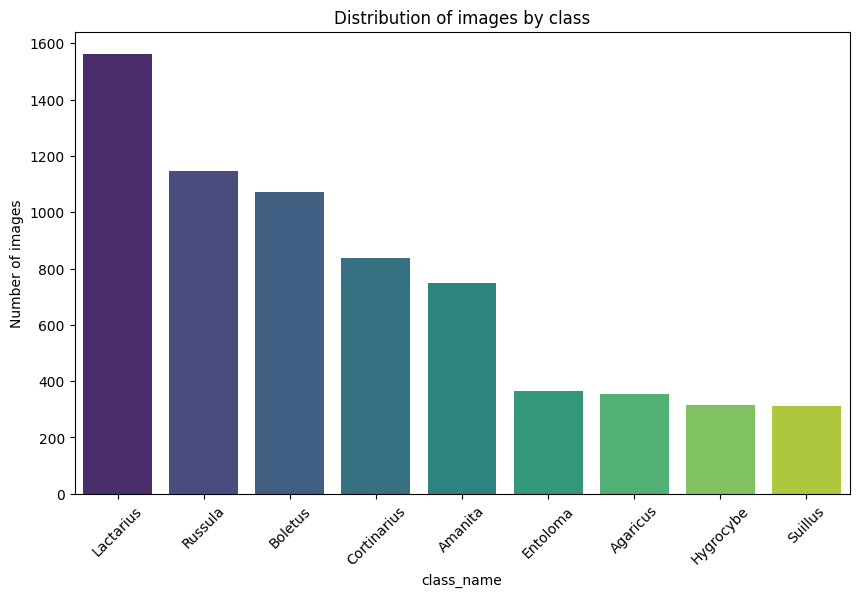

   count   class_name
6   1563    Lactarius
7   1148      Russula
2   1073      Boletus
3    836  Cortinarius
1    750      Amanita
4    364     Entoloma
0    353     Agaricus
5    316    Hygrocybe
8    311      Suillus


In [32]:
classCounts = Counter([label for _, label in fullDataset.samples])
countDf = pd.DataFrame.from_dict(classCounts, orient='index', columns=['count']).sort_values('count', ascending=False)
countDf['class_name'] = [fullDataset.classes[i] for i in countDf.index]

plt.figure(figsize=(10,6))
sns.barplot(data=countDf, x='class_name', y='count', palette='viridis')
plt.title('Distribution of images by class')
plt.xticks(rotation=45)
plt.ylabel('Number of images')
plt.show()

print(countDf)

### Разделение на train и test

In [33]:
def getMushroomDataLoaders(testSize=0.2, batchSize=32, randomState=42, numWorkers=0):
    fullDatasetLocal = datasets.ImageFolder(dataDir, transform=testTransform)

    trainSize = int((1 - testSize) * len(fullDatasetLocal))
    testSizeActual = len(fullDatasetLocal) - trainSize
    trainDataset, testDataset = random_split(fullDatasetLocal, [trainSize, testSizeActual], generator=torch.Generator().manual_seed(randomState))

    trainDataset.dataset.transform = trainTransform
    testDataset.dataset.transform = testTransform

    trainLoader = DataLoader(
        trainDataset,
        batch_size=batchSize,
        shuffle=True,
        num_workers=numWorkers
    )

    testLoader = DataLoader(
        testDataset,
        batch_size=batchSize,
        shuffle=False,
        num_workers=numWorkers
    )
    
    return trainLoader, testLoader, trainDataset, testDataset

In [34]:
trainLoader, testLoader, trainDataset, testDataset = getMushroomDataLoaders(testSize=0.2, batchSize=32, numWorkers=2)

print(f"Train size: {len(trainDataset)}")
print(f"Test size: {len(testDataset)}")

batchFeatures, batchLabels = next(iter(trainLoader))
print(f"Batch features shape: {batchFeatures.shape}, labels shape: {batchLabels.shape}")

Train size: 5371
Test size: 1343
Batch features shape: torch.Size([32, 3, 224, 224]), labels shape: torch.Size([32])


### Модель CNN

In [35]:
class MushroomCNN(nn.Module):
    def __init__(self, numClasses=9):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 112
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 56
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 28
            
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 14 → 7
        )
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256, numClasses)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
    
def createModelByName(modelName: str, numClasses: int):
    if modelName == "MushroomCNN":
        modelInstance = MushroomCNN(numClasses=numClasses)
        return modelInstance.to(device)
    
    if modelName == "ResNet18":
        pretrainedModel = models.resnet18(pretrained=True)
        numFeatures = pretrainedModel.fc.in_features
        pretrainedModel.fc = nn.Linear(numFeatures, numClasses)
        for nameParam, param in pretrainedModel.named_parameters():
            if "fc" not in nameParam:
                param.requires_grad = False
        return pretrainedModel.to(device)
    
    if modelName == "EfficientNetB0":
        pretrainedModel = models.efficientnet_b0(pretrained=True)
        numFeatures = pretrainedModel.classifier[1].in_features
        pretrainedModel.classifier[1] = nn.Linear(numFeatures, numClasses)
        for nameParam, param in pretrainedModel.named_parameters():
            if "classifier" not in nameParam:
                param.requires_grad = False
        return pretrainedModel.to(device)

    if modelName == "DenseNet121":
        pretrainedModel = models.densenet121(pretrained=True)
        numFeatures = pretrainedModel.classifier.in_features
        pretrainedModel.classifier = nn.Linear(numFeatures, numClasses)
        for nameParam, param in pretrainedModel.named_parameters():
            if "classifier" not in nameParam:
                param.requires_grad = False
        return pretrainedModel.to(device)
    
    if modelName == "MobileNetV3_Small":
        pretrainedModel = models.mobilenet_v3_small(pretrained=True)
        numFeatures = pretrainedModel.classifier[0].in_features if isinstance(pretrainedModel.classifier, nn.Sequential) else pretrainedModel.classifier.in_features
        pretrainedModel.classifier = nn.Sequential(
            nn.Linear(numFeatures, numClasses)
        )
        for nameParam, param in pretrainedModel.named_parameters():
            if "classifier" not in nameParam:
                param.requires_grad = False
        return pretrainedModel.to(device)

    raise ValueError(f"Unknown modelName: {modelName}")

### Функции обучения, валидации и подсчёта метрик

In [36]:
def trainOneEpoch(modelNet, dataLoaderTrain, optimizerAdam, criterionLoss):
    modelNet.train()
    runningLoss = 0.0
    runningSamples = 0
    allPredictions = []
    allTargets = []

    for batchFeatures, batchLabels in dataLoaderTrain:
        batchFeatures = batchFeatures.to(device)
        batchLabels = batchLabels.to(device)

        optimizerAdam.zero_grad()
        logits = modelNet(batchFeatures)
        lossValue = criterionLoss(logits, batchLabels)
        lossValue.backward()
        optimizerAdam.step()

        batchSize = batchFeatures.size(0)
        runningLoss += lossValue.item() * batchSize
        runningSamples += batchSize

        preds = torch.argmax(logits, dim=1)
        allPredictions.append(preds.detach().cpu().numpy())
        allTargets.append(batchLabels.detach().cpu().numpy())

    epochLoss = runningLoss / runningSamples

    allPredictions = np.concatenate(allPredictions)
    allTargets = np.concatenate(allTargets)
    accuracyOverall = (allPredictions == allTargets).mean()
    
    return epochLoss, accuracyOverall

def evaluateModel(modelNet, dataLoaderEval):
    modelNet.eval()
    criterionLoss = nn.CrossEntropyLoss()
    runningLoss = 0.0
    runningSamples = 0
    allPredictions = []
    allTargets = []

    with torch.no_grad():
        for batchFeatures, batchLabels in dataLoaderEval:
            batchFeatures = batchFeatures.to(device)
            batchLabels = batchLabels.to(device)

            logits = modelNet(batchFeatures)
            lossValue = criterionLoss(logits, batchLabels)

            batchSize = batchFeatures.size(0)
            runningLoss += lossValue.item() * batchSize
            runningSamples += batchSize

            preds = torch.argmax(logits, dim=1)
            allPredictions.append(preds.cpu().numpy())
            allTargets.append(batchLabels.cpu().numpy())

    epochLoss = runningLoss / runningSamples
    allPredictions = np.concatenate(allPredictions)
    allTargets = np.concatenate(allTargets)
    accuracyOverall = (allPredictions == allTargets).mean()

    return epochLoss, accuracyOverall, allTargets, allPredictions

def trainAndEvaluateModel(modelName: str,
                          numEpochs: int = 10,
                          batchSize: int = 16,
                          learningRate: float = 1e-3):
    print("="*80)
    print(f"Запуск: {modelName}")
    trainLoaderLocal, testLoaderLocal, trainDatasetLocal, testDatasetLocal = getMushroomDataLoaders(testSize=0.2,
                                                                                                   batchSize=batchSize,
                                                                                                   randomState=randomSeed)
    numClassesLocal = len(trainDatasetLocal.dataset.classes)
    modelInstance = createModelByName(modelName, numClassesLocal)

    optimizerLocal = optim.Adam(filter(lambda p: p.requires_grad, modelInstance.parameters()),
                                lr=learningRate,
                                weight_decay=1e-4)
    criterionLocal = nn.CrossEntropyLoss()

    trainLossHistoryLocal = []
    trainAccuracyHistoryLocal = []
    testLossHistoryLocal = []
    testAccuracyHistoryLocal = []

    bestTestAccuracyLocal = 0.0
    bestModelStateLocal = None
    bestEpochLocal = 0

    startTime = time.time()
    for epochIndex in range(1, numEpochs+1):
        trainLoss, trainAccuracy = trainOneEpoch(modelInstance, trainLoaderLocal, optimizerLocal, criterionLocal)
        testLoss, testAccuracy, _, _ = evaluateModel(modelInstance, testLoaderLocal)

        trainLossHistoryLocal.append(trainLoss)
        trainAccuracyHistoryLocal.append(trainAccuracy)
        testLossHistoryLocal.append(testLoss)
        testAccuracyHistoryLocal.append(testAccuracy)

        if testAccuracy > bestTestAccuracyLocal:
            bestTestAccuracyLocal = testAccuracy
            bestModelStateLocal = copy.deepcopy(modelInstance.state_dict())
            bestEpochLocal = epochIndex
        
        if epochIndex % 1 == 0 or epochIndex == 1:
            print(f"{modelName} | Epoch {epochIndex:03d} | train_loss = {trainLoss:.4f} | test_loss = {testLoss:.4f} | train_acc = {trainAccuracy:.4f} | test_acc = {testAccuracy:.4f}")

    elapsedTime = time.time() - startTime
    testLossFinal, testAccuracyFinal, allTargetsLocal, allPredictionsLocal = evaluateModel(modelInstance, testLoaderLocal)

    confusionMatrixLocal = confusion_matrix(allTargetsLocal, allPredictionsLocal)
    classNamesLocal = testDatasetLocal.dataset.classes
    classificationReportLocal = classification_report(allTargetsLocal, allPredictionsLocal, target_names=classNamesLocal, digits=4, output_dict=False)

    resultDict = {
        "modelName": modelName,
        "numEpochs": numEpochs,
        "batchSize": batchSize,
        "learningRate": learningRate,
        "trainLossHistory": trainLossHistoryLocal,
        "trainAccuracyHistory": trainAccuracyHistoryLocal,
        "testLossHistory": testLossHistoryLocal,
        "testAccuracyHistory": testAccuracyHistoryLocal,
        "bestTestAccuracy": bestTestAccuracyLocal,
        "bestEpoch": bestEpochLocal,
        "finalTestLoss": testLossFinal,
        "finalTestAccuracy": testAccuracyFinal,
        "confusionMatrix": confusionMatrixLocal,
        "classificationReportText": classificationReportLocal,
        "classNames": classNamesLocal,
        "elapsedTimeSeconds": elapsedTime
    }
    
    return resultDict


### Запуск обучения

In [37]:
modelsToRun = ["MushroomCNN", "ResNet18", "EfficientNetB0", "DenseNet121", "MobileNetV3_Small"]
resultsList = []

batchSize = 16
learningRate = 1e-3
numEpochs = 10

for modelName in modelsToRun:
    resultLocal = trainAndEvaluateModel(modelName,
                                        numEpochs=numEpochs,
                                        batchSize=batchSize,
                                        learningRate=learningRate)
    resultsList.append(resultLocal)

summaryRows = []
for res in resultsList:
    summaryRows.append({
        "modelName": res["modelName"],
        "bestTestAccuracy": res["bestTestAccuracy"],
        "finalTestAccuracy": res["finalTestAccuracy"],
        "finalTestLoss": res["finalTestLoss"],
        "elapsedTimeSeconds": res["elapsedTimeSeconds"]
    })

summaryDf = pd.DataFrame(summaryRows).sort_values("finalTestAccuracy", ascending=False)
print("\nСводная таблица результатов:")
display(summaryDf)

Запуск: MushroomCNN
MushroomCNN | Epoch 001 | train_loss = 1.8878 | test_loss = 1.8914 | train_acc = 0.3011 | test_acc = 0.2978
MushroomCNN | Epoch 002 | train_loss = 1.7855 | test_loss = 1.7711 | train_acc = 0.3573 | test_acc = 0.3641
MushroomCNN | Epoch 003 | train_loss = 1.7114 | test_loss = 1.6841 | train_acc = 0.3841 | test_acc = 0.3917
MushroomCNN | Epoch 004 | train_loss = 1.6647 | test_loss = 1.5918 | train_acc = 0.3992 | test_acc = 0.4386
MushroomCNN | Epoch 005 | train_loss = 1.6336 | test_loss = 1.6050 | train_acc = 0.4206 | test_acc = 0.4430
MushroomCNN | Epoch 006 | train_loss = 1.5822 | test_loss = 1.5383 | train_acc = 0.4288 | test_acc = 0.4698
MushroomCNN | Epoch 007 | train_loss = 1.5440 | test_loss = 1.5555 | train_acc = 0.4528 | test_acc = 0.4497
MushroomCNN | Epoch 008 | train_loss = 1.5156 | test_loss = 1.5099 | train_acc = 0.4653 | test_acc = 0.4929
MushroomCNN | Epoch 009 | train_loss = 1.4871 | test_loss = 1.4881 | train_acc = 0.4722 | test_acc = 0.4803
Mushroom

,modelName,bestTestAccuracy,finalTestAccuracy,finalTestLoss,elapsedTimeSeconds
3,DenseNet121,0.772897,0.772897,0.675291,2297.263155
1,ResNet18,0.725987,0.717796,0.803268,1060.364094
2,EfficientNetB0,0.724497,0.717796,0.787819,963.858037
4,MobileNetV3_Small,0.681310,0.678332,0.875560,424.843080
0,MushroomCNN,0.524200,0.524200,1.434703,1907.253856


### Визуализация

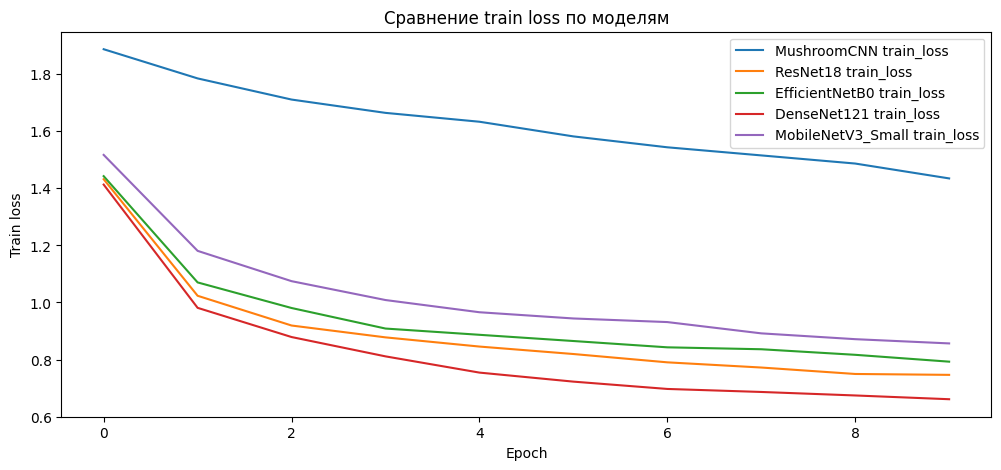

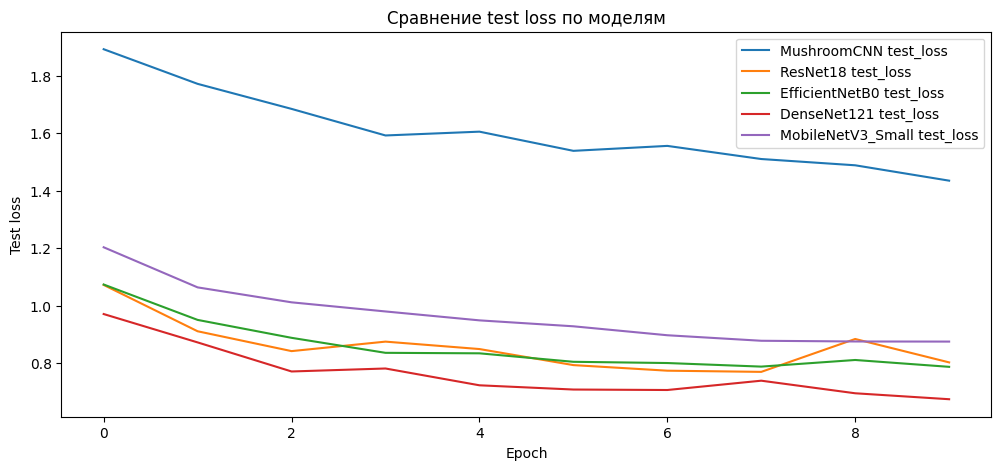

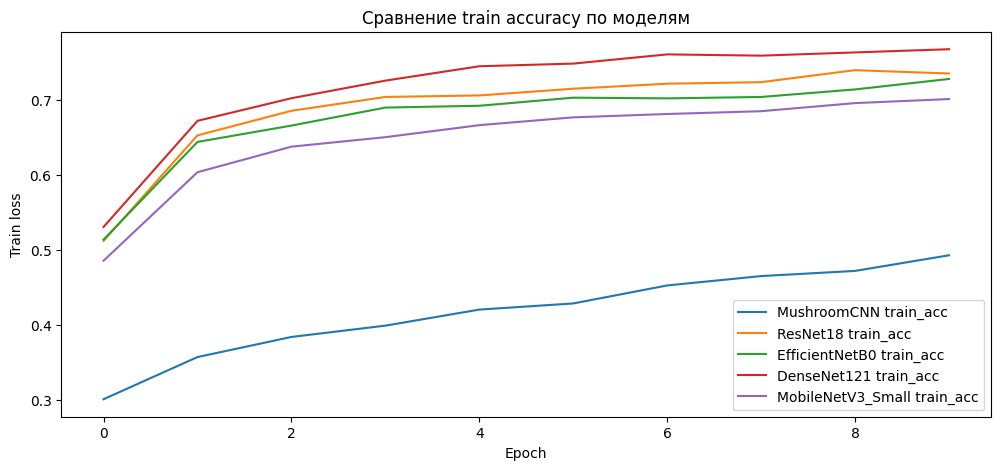

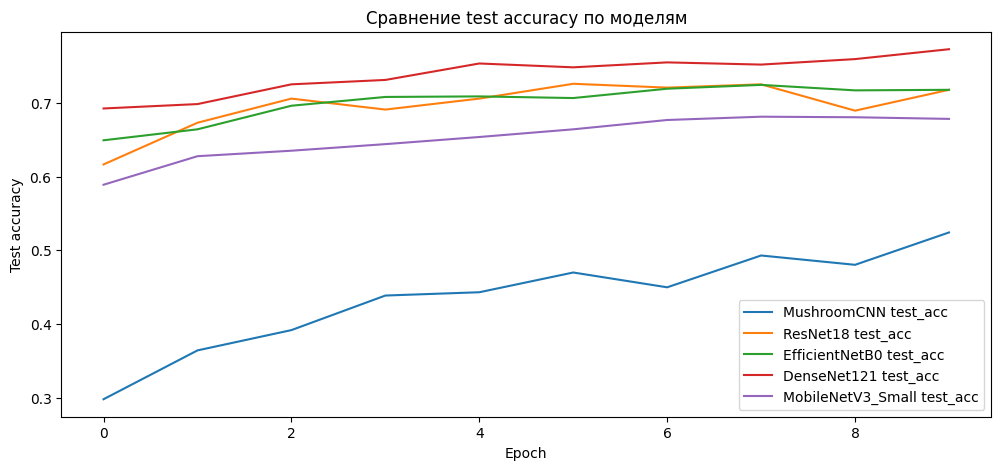

In [38]:
plt.figure(figsize=(12,5))
for res in resultsList:
    plt.plot(res["trainLossHistory"], label=f"{res['modelName']} train_loss")
plt.xlabel("Epoch")
plt.ylabel("Train loss")
plt.legend()
plt.title("Сравнение train loss по моделям")
plt.show()

plt.figure(figsize=(12,5))
for res in resultsList:
    plt.plot(res["testLossHistory"], label=f"{res['modelName']} test_loss")
plt.xlabel("Epoch")
plt.ylabel("Test loss")
plt.legend()
plt.title("Сравнение test loss по моделям")
plt.show()

plt.figure(figsize=(12,5))
for res in resultsList:
    plt.plot(res["trainAccuracyHistory"], label=f"{res['modelName']} train_acc")
plt.xlabel("Epoch")
plt.ylabel("Train loss")
plt.legend()
plt.title("Сравнение train accuracy по моделям")
plt.show()

plt.figure(figsize=(12,5))
for res in resultsList:
    plt.plot(res["testAccuracyHistory"], label=f"{res['modelName']} test_acc")
plt.xlabel("Epoch")
plt.ylabel("Test accuracy")
plt.legend()
plt.title("Сравнение test accuracy по моделям")
plt.show()

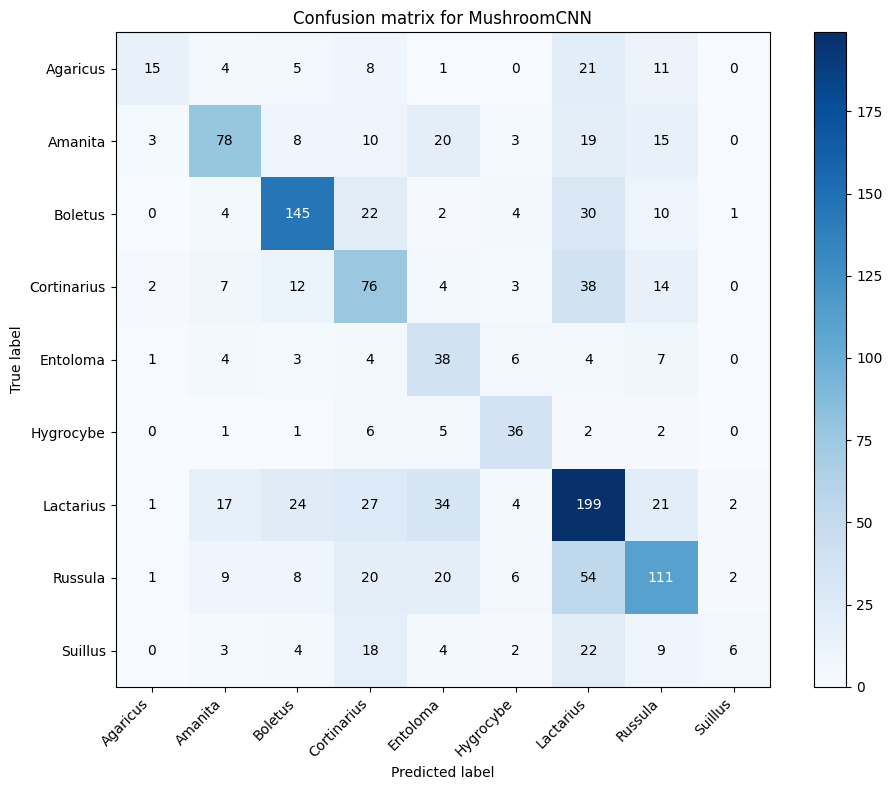

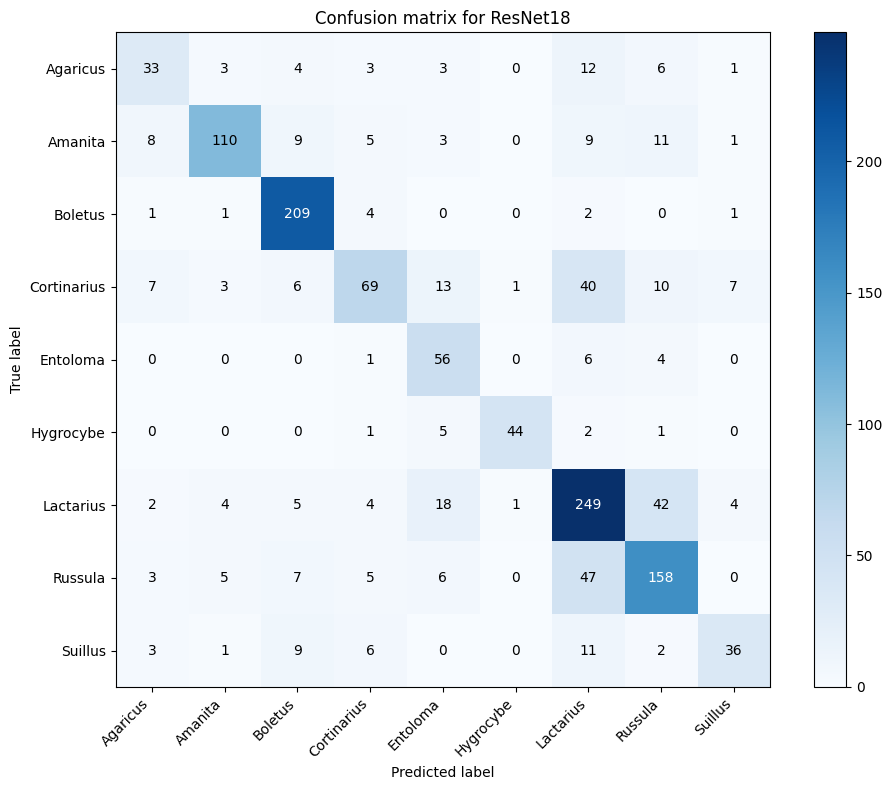

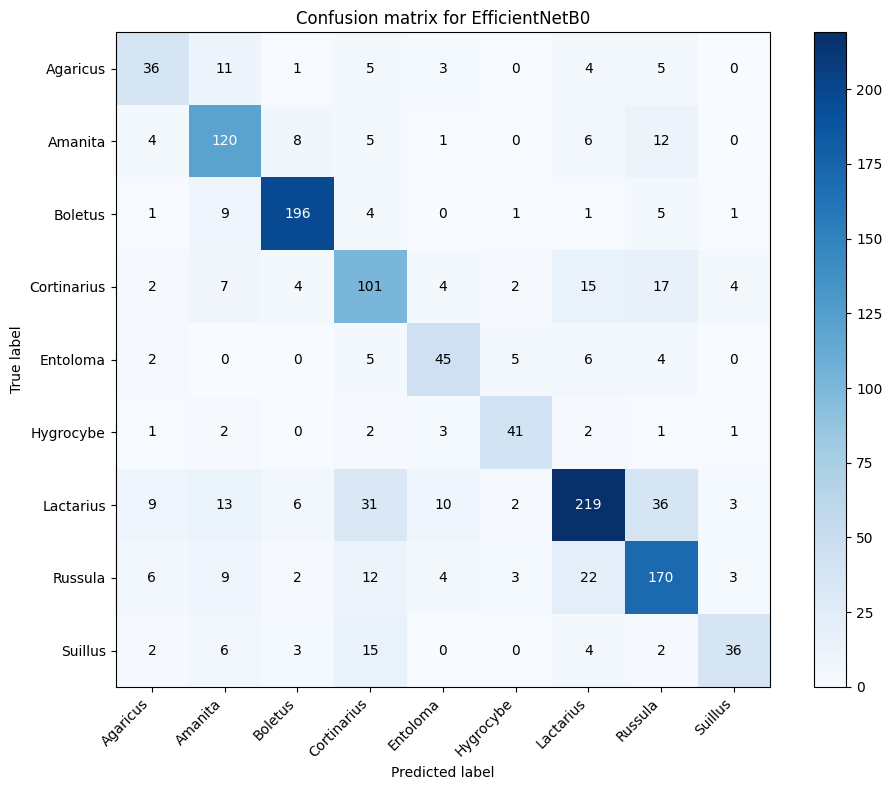

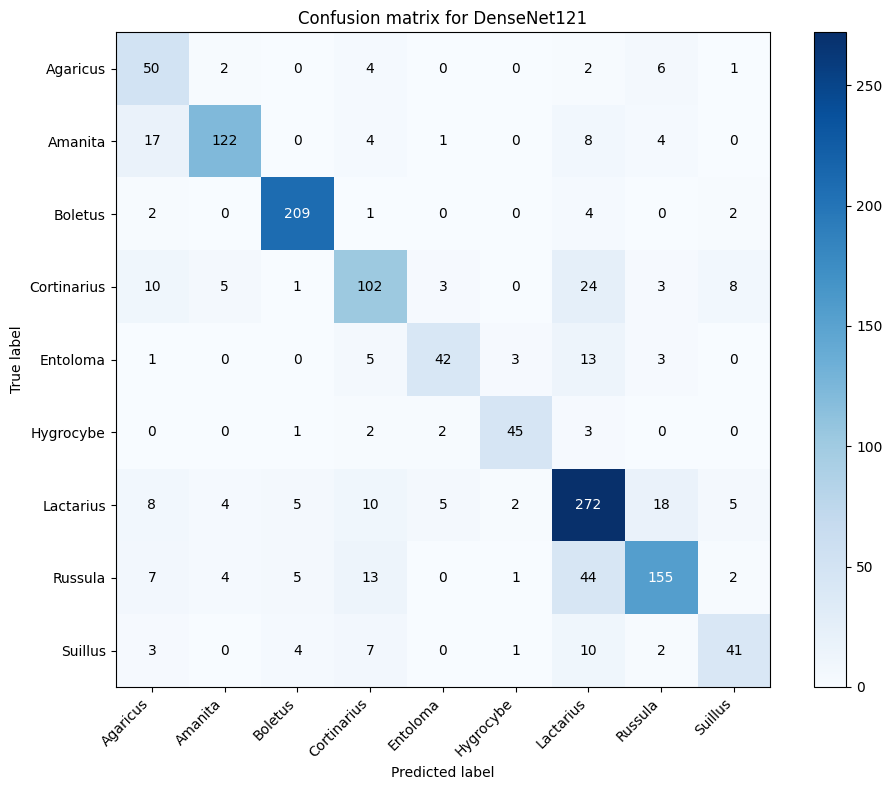

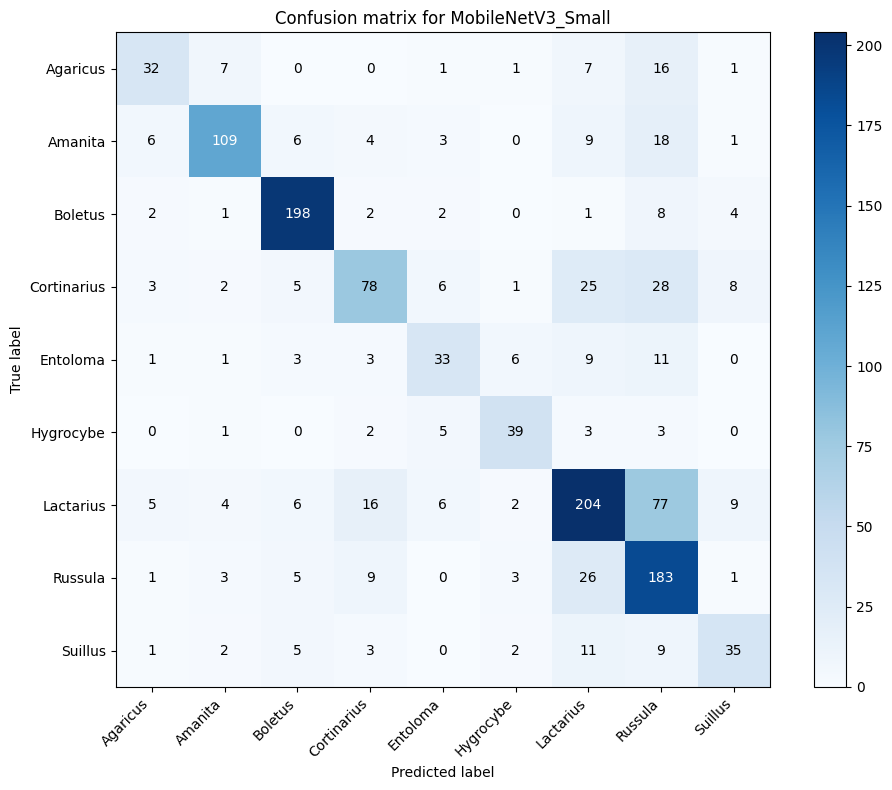

In [39]:
class_names = testDataset.dataset.classes
for res in resultsList:
    plt.figure(figsize=(10,8))
    im = plt.imshow(res["confusionMatrix"], interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion matrix for {res['modelName']}")
    plt.colorbar(im)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
    plt.yticks(range(len(class_names)), class_names)
    for i in range(res["confusionMatrix"].shape[0]):
        for j in range(res["confusionMatrix"].shape[1]):
            plt.text(j, i, res["confusionMatrix"][i, j], ha="center", va="center", color="white" if res["confusionMatrix"][i,j] > res["confusionMatrix"].max()/2 else "black")
    plt.tight_layout()
    plt.show()

### Оценка по классам и матрица ошибок

In [43]:
for res in resultsList:
    print("\n" + "="*80)
    print(f"Модель: {res['modelName']} | bestTestAccuracy={res['bestTestAccuracy']:.4f} | finalTestAccuracy={res['finalTestAccuracy']:.4f}\n")

    classNames = testDataset.dataset.classes
    accuracyPerClass = np.sort(res["confusionMatrix"].diagonal() / res["confusionMatrix"].sum(axis=1))[::-1]
    for classIndex, classAccuracy in enumerate(accuracyPerClass):
        print(f"Class '{classNames[classIndex]}': accuracy = {classAccuracy:.4f}")

    print("\nClassification report:\n")
    print(res["classificationReportText"])

    print("\nConfusion Matrix:\n")
    print(res["confusionMatrix"])

    print("="*80 + "\n")


Модель: MushroomCNN | bestTestAccuracy=0.5242 | finalTestAccuracy=0.5242

Class 'Agaricus': accuracy = 0.6792
Class 'Amanita': accuracy = 0.6651
Class 'Boletus': accuracy = 0.6049
Class 'Cortinarius': accuracy = 0.5672
Class 'Entoloma': accuracy = 0.5000
Class 'Hygrocybe': accuracy = 0.4872
Class 'Lactarius': accuracy = 0.4805
Class 'Russula': accuracy = 0.2308
Class 'Suillus': accuracy = 0.0882

Classification report:

              precision    recall  f1-score   support

    Agaricus     0.6522    0.2308    0.3409        65
     Amanita     0.6142    0.5000    0.5512       156
     Boletus     0.6905    0.6651    0.6776       218
 Cortinarius     0.3979    0.4872    0.4380       156
    Entoloma     0.2969    0.5672    0.3897        67
   Hygrocybe     0.5625    0.6792    0.6154        53
   Lactarius     0.5116    0.6049    0.5543       329
     Russula     0.5550    0.4805    0.5151       231
     Suillus     0.5455    0.0882    0.1519        68

    accuracy                     